# Прогнозирование оттока клиентов для оператора связи "Ниединогоразрыва.ком"

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Информация о договорах актуальна на 1 февраля 2020.

## Предобработка данных

Импортируем необходимые для работы библиотеки

In [1]:
! pip install imbalanced-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat


import time

from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier



from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 311022

Прочтём все файлы и сохраним их в переменных.

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

Сохраним все датафреймы в переменной.

In [4]:
datasets = [contract, personal, internet, phone]

Выведем общую информацию о таблицах.

In [5]:
for data in datasets:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 

Исходя из названий столбцов в таблицах и комментариев к данным мы можем сделать следующие выводы:

- в таблице contract содержится информация о договоре: id пользователя, дата начала и окончания действия договора, способ оплаты, ежемесячные платежи, сумма платежей; не очень понятна информация, которая хранится в столбцах Type и PaperlessBilling;
- в таблице personal хранятся персональные данные клиента: его пол, члены семьи;
- в таблице internet находится информация об интернет-услугах: интернет безопасность, резервное копирование, антивирус, блокировка небезопасных сайтов, выделенная линия техподдержки, стриминговое телевидение, каталог фильмов;
- в таблице phone хранится информация о стационарной телефонной связи.


В каждой таблице есть столбец с уникальным идентификатором пользователя. В таблицах различается количество строк, возможно некоторые клиенты используют не все возможные услуги.

Проверим данные на наличие дубликатов

In [6]:
for data in datasets:
    print(data.duplicated().sum())

0
0
0
0


Каждый пользователь действительно уникален, в таблицах нет дубликатов.

Проверим количество пропусков в датасетах

In [7]:
for data in datasets:
    print(data.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
customerID       0
MultipleLines    0
dtype: int64


Пропуски тоже отсутствуют.

Выведем первые и последние строки таблиц на экран

In [8]:
for data in datasets:
    display(data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Мы видим, что в таблице contract различается тип даты в столбцах с датой начала и окончания договора, во многих строках не указана дата окончания договора. Возможно, указана дата окончания договора у тех клиентов, которые прекратили пользоваться услугами компании. В таблице phone только обозначено использует или нет клиент стационарную связь с подключением к нескольким линиям.

Столбец TotalCharges имеет тип данных object, но в нём хранятся числовые данные.

Заменим yes и no в таблицах на 1 и 0 соответственно. Для этого используем функцию.

In [10]:
def one_zero(binar):
    if binar == 'Yes':
        return 1
    elif binar == 'No':
        return 0

Создадим список столбцов, в которых необходимо произвести замену.

In [11]:
column_binar = ['PaperlessBilling', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines']

Проведём замену

In [12]:
for col in column_binar:
    for data in datasets:
        if col in data.columns:
            data[col] = data[col].apply(one_zero)

Убедимся, что данные заменены корректно

In [13]:
for data in datasets:
    display(data.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0


Так как нам необходимо, чтобы модель предсказывала, планирует ли клиент уйти, а не конкретную дату его ухода, добавим новый столбец, в котором отразим перестал ли клиент пользоваться услугами компании. Если значение в столбце EndDate равно "No", то значит клиент не ушел и в столбце Churn (целевой признак) равен 0. Если дата ухода есть, то целевой признак равен 1.

In [14]:
contract['Churn'] = contract.apply(lambda x: 0 if x.EndDate == 'No' else 1, axis=1)

В столбце с окончанием действия договора есть значения no, значит, клиент в данный момент пользуется услугами компании. Данные в таблицах актуальны на 1 февраля 2020 года, заменим значения no на эту дату.

In [15]:
contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])

Убедимся, что замена прошла корректно.

In [16]:
print(contract[contract['EndDate'] == 'No'].shape[0])

0


Изменим тип данных в столбце с датами.

In [17]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Посмотрим уникальные значения в столбце TotalCharges

In [18]:
contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

Значения разнообразные, найдём максимальное

In [19]:
contract['TotalCharges'].unique().max()

'999.9'

И посмотрим минимальное значения

In [20]:
contract['TotalCharges'].unique().min()

' '

В столбце есть пробелы, эти строки не были помечены пропусками при вызове функции. Рассмотрим данные с пробелом в этом столбце поближе.

In [21]:
contract.loc[contract.loc[:, 'TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,,0


Во всех данных в столбце EndDate указана дата 2 февраля 2020 года, вероятно, эти клиенты недавно присоединились и ещё не вносили оплату. Заменим пробелы нулевым значением, а потом изменим тип данных.

In [22]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

Добавим столбец с количеством дней, в течение которых клиент пользовался услугами компании.

In [28]:
contract['Days'] = (contract['EndDate'] - contract['BeginDate']).dt.days

Теперь посмотрим распределение данных на графиках.

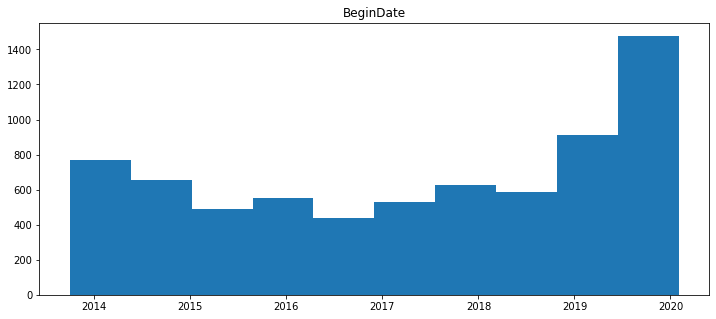

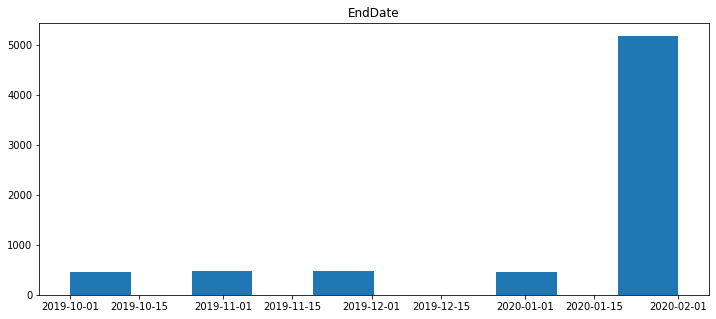

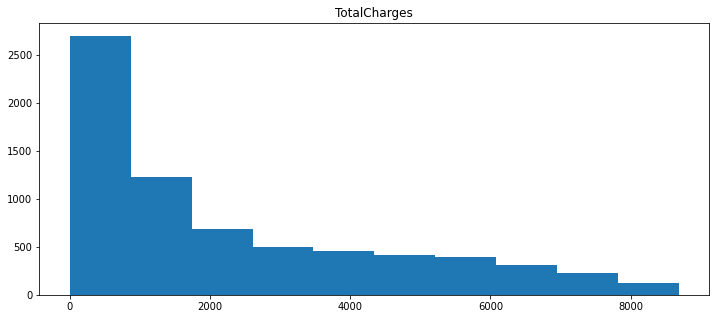

In [31]:
column = ['BeginDate', 'EndDate', 'TotalCharges']
for i in column:
    plt.figure(figsize=(12, 5))
    plt.hist(contract[i])
    plt.title(i)
    plt.show()

На первом графике мы видим, что в 2014 году у компании "Ниединогоразрыва.ком" появилось много новых клиентов, в следующие годы также заметен прирост. Большой скачок в количестве новых клиентов произошёл в 2019 году. Из данных за 2020 год в нашем распоряжении только один месяц, поэтому здесь рано говорить о количестве новых клиентов.

На втором графике в 2019 и в 2020 годах заметно большое количество ушедших клиентов, при чём их количество в 2020 году в несколько раз превышает количество 2019 года.

На третьем графике распределения ежемесячной оплаты мы видим много значений около нуля, вероятно, эти клиенты недавно начали пользоваться услугами компании "Ниединогоразрыва.ком", так как в этом столбце мы заменяли пустые значения нулевыми именно с таким предположением.

Посмотрим на распределение по количеству дней пользования.

<AxesSubplot:xlabel='Days', ylabel='Density'>

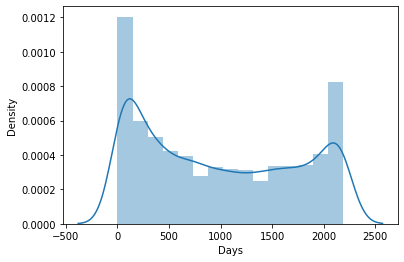

In [34]:
warnings.filterwarnings('ignore')

sns.distplot(contract['Days'])

На графике мы видим, что многие клиенты пользовались услугами компании недолго - значения лежат возле нуля, но также много значений, когда пользовались более 2000 дней. Рассмотри данные поближе в диапазоне 100 дней.

<AxesSubplot:xlabel='Days', ylabel='Density'>

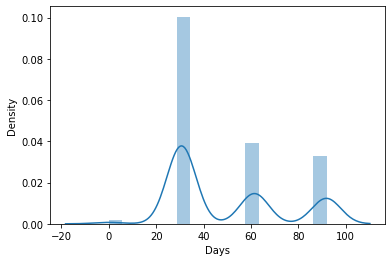

In [36]:
warnings.filterwarnings('ignore')

sns.distplot(contract[contract['Days']<100]['Days'])

Мы видим, что некоторые клиенты уходят уже через месяц. Возможно, их не устраивают тарифы, которые предлагает компания.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Density'>

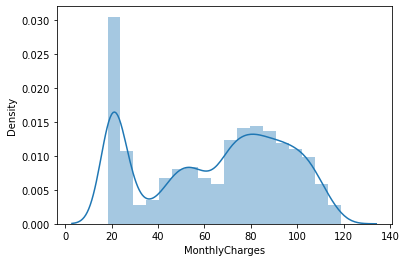

In [37]:
warnings.filterwarnings('ignore')

sns.distplot(contract['MonthlyCharges'])

На графике заметно, что многие клиенты пользуются недорогим тарифом за 20$.

Посмотрим на распределение по общей сумме оплаты.

Type 
 Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


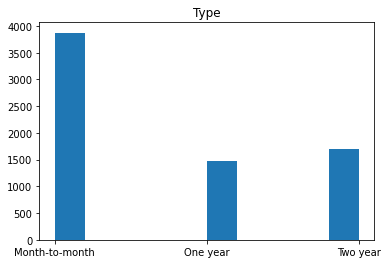

PaperlessBilling 
 1    4171
0    2872
Name: PaperlessBilling, dtype: int64


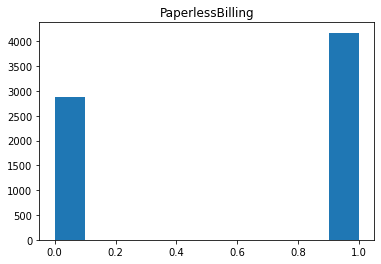

PaymentMethod 
 Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


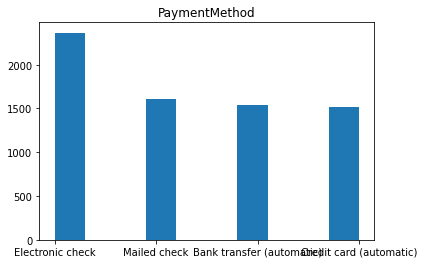

In [38]:
column = ['Type', 'PaperlessBilling', 'PaymentMethod']
for i in column:
    print(i,'\n',contract[i].value_counts())
    plt.hist(contract[i])
    plt.title(i)
    plt.show()

Мы видим, что наиболее популярна ежемесячная оплата, электронный документ об оплате получает большинство клиентов. Также распространена оплата электронным чеком, остальные варианты находятся примерно на одном уровне.

Рассмотрим персональные данные клиента.

gender 
 Male      3555
Female    3488
Name: gender, dtype: int64


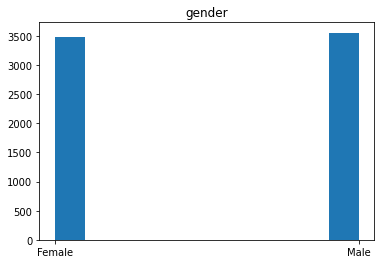

SeniorCitizen 
 0    5901
1    1142
Name: SeniorCitizen, dtype: int64


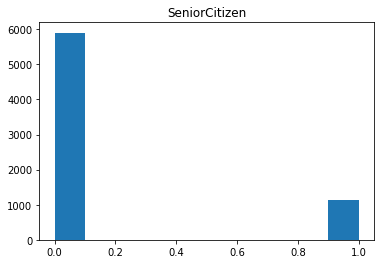

Partner 
 0    3641
1    3402
Name: Partner, dtype: int64


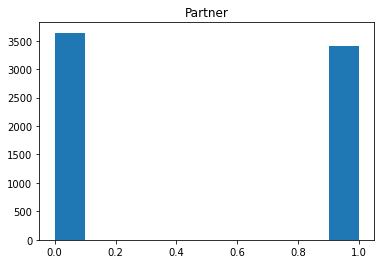

Dependents 
 0    4933
1    2110
Name: Dependents, dtype: int64


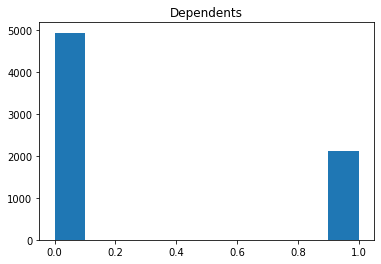

In [39]:
columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
for i in columns:
    print(i,'\n',personal[i].value_counts())
    plt.hist(personal[i])
    plt.title(i)
    plt.show()

Количество клиентов мужчин и женщин находится примерно на одном уровне, пенсионеров среди клиентов немного, одиноких и людей в отношениях тоже примерно поравну. Большинство клиентов не имеют иждивенцев (вероятно, речь идёт о несовершеннолетних детях).

Теперь помотрим распределение по услугам в таблице internet.

OnlineSecurity 
 0    3498
1    2019
Name: OnlineSecurity, dtype: int64


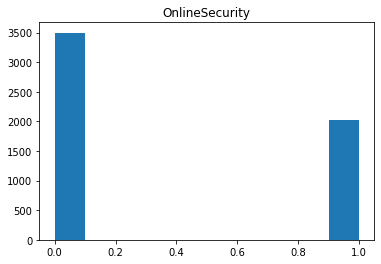

OnlineBackup 
 0    3088
1    2429
Name: OnlineBackup, dtype: int64


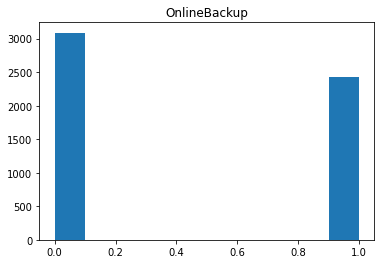

DeviceProtection 
 0    3095
1    2422
Name: DeviceProtection, dtype: int64


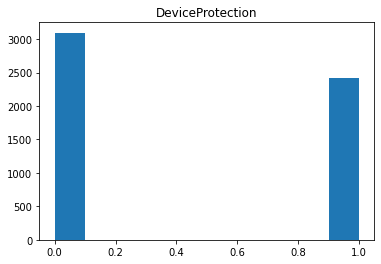

TechSupport 
 0    3473
1    2044
Name: TechSupport, dtype: int64


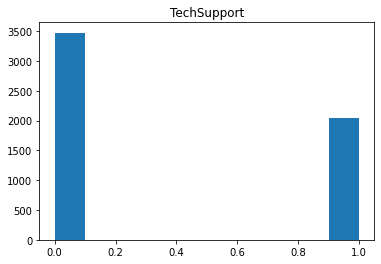

StreamingTV 
 0    2810
1    2707
Name: StreamingTV, dtype: int64


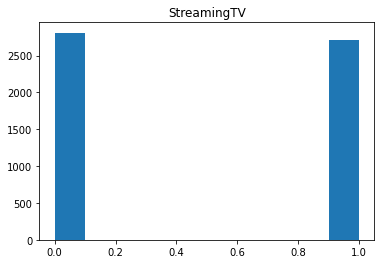

StreamingMovies 
 0    2785
1    2732
Name: StreamingMovies, dtype: int64


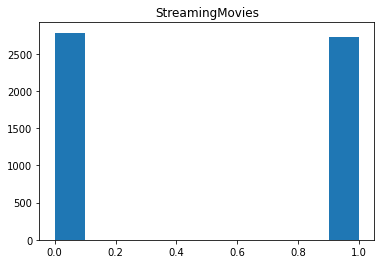

In [40]:
binary_col = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']
for i in binary_col:
    print(i,'\n',internet[i].value_counts())
    plt.hist(internet[i])
    plt.title(i)
    plt.show()

Распределение по всем сервисам немного колеблется, но если рассматривать графики в совокупности, то можно сделать вывод, что большинство клиентов не используют дополнительные сервисы.

Посмотрим как много клиентов используют стационарную телефонную связь.

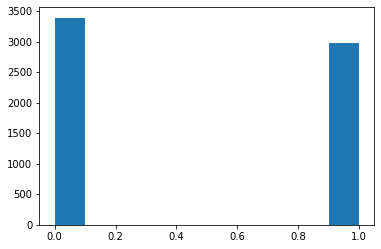

In [41]:
plt.hist(phone['MultipleLines'])
plt.show()

Клиентов, не пользующихся стационарной телефонной связью, чуть больше.

Объединим все таблицы в одну большую.

In [42]:
df = contract.merge(personal, on=['customerID'], how='outer')
df = df.merge(internet, on=['customerID'], how='outer')
df = df.merge(phone, on=['customerID'], how='outer')

In [43]:
display(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,31,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,1036,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.50,0,730,...,1,1,DSL,1.0,0.0,1.0,1.0,1.0,1.0,1.0
7039,2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90,0,2191,...,1,1,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1.0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,0,337,...,1,1,DSL,1.0,0.0,0.0,0.0,0.0,0.0,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,1,123,...,1,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Теперь все данные хранятся в одной таблице.

После объединения таблиц наверняка образовались пропуски, проверим это.

In [44]:
print(df.isna().sum())
df.info()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
Days                   0
MonthsContract         0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-nul

Образовавшиеся пропуски заполним нулевым значением, так как в таблицах не было информации о клиентах, значит, они не пользовались услугой.

In [45]:
for i in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',\
          'StreamingTV', 'StreamingMovies']:
    df[i] = df[i].fillna(0)

Теперь пропусков нет

In [46]:
print(data.duplicated().sum())

0


Дубликатов нет.

После объединения таблиц изменился тип данных в некоторых столбцах.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Days              7043 non-null   int64         
 10  MonthsContract    7043 non-null   int64         
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   int64         
 14  Dependents        7043 n

In [48]:
df['TotalCharges'] = df['TotalCharges'].astype('int64')
df['OnlineSecurity'] = df['OnlineSecurity'].astype('int64')
df['OnlineBackup'] = df['OnlineBackup'].astype('int64')
df['DeviceProtection'] = df['DeviceProtection'].astype('int64')
df['TechSupport'] = df['TechSupport'].astype('int64')
df['StreamingTV'] = df['StreamingTV'].astype('int64')
df['StreamingMovies'] = df['StreamingMovies'].astype('int64')
df['MultipleLines'] = df['MultipleLines'].astype('int64')

Посмтроим тепловую карту, чтобы отследить корреляцию признаков.

<AxesSubplot:>

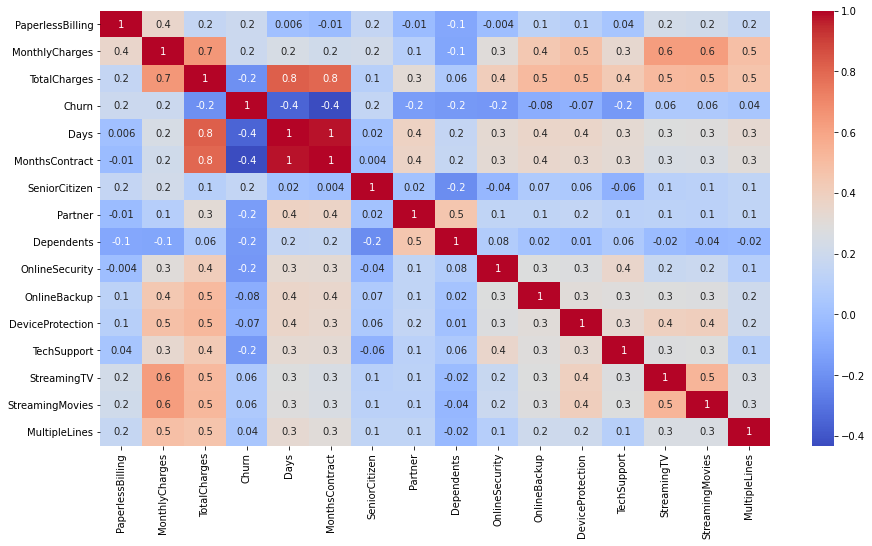

In [49]:
plt.figure(figsize = (15,8))

sns.heatmap(df.corr(), annot = True, fmt='.1g', cmap= 'coolwarm')

Мы видим, что в большинстве столбцов корреляция низкая. Встречается средняя корреляция между использованием дополнительных сервисов и суммой оплаты. Также довольно большая корреляция между ежемесячной оплатой и общей суммой оплаты, так как общая сумма оплаты зависит от того сколько месяцев клиент пользовался услугами компании и ежемесячной оплаты в зависимости от его тарифа и используемых сервисов.

### **Вывод**

Итак, в ходе предобработки данных мы:
- изучили имеющиеся в нашем распоряжении таблицы, дубликатов и пропусков в них не обнаружили, но нашли пробелы в одном столбце, их заменили нулевым значением;
- изменили тип данных в некоторых столбцах, перевели в 0 и 1 признаки со значениями Yes и No для удобства объединения и сравнения;
- посмотрели распределение данных по столбцам;
- объединили таблицы в одну.

Далее можно переходить к обучению моделей.

**План:**
1. Постановка задачи. Этот этап необходим для понимания итогового результата, который необходимо получить.
2. Первичное знакомство / загрузка данных. Данные бывают разного качества и на данном этапе с ними необходимо познакомиться, обработать пропуски, дубликаты, изменить типы столбцов, удалить неинформативные или добавить новые, объединить таблицы, если такие шаги необходимы.
3. Исследовательский анализ данных. Теперь можно переходить к непосредственному исследованию данных, делать предположения на основе имеющихся таблиц. Также на этом этапе осуществляется визуализация данных, с помощью различных графиков можно рассмотреть распределение данных, с которыми ведётся работа, выявить выбросы, аномальные значения. 
4. Обучение моделей, сравнение результатов, выбор наилучшей модели. Для разных задач могут подходить различные модеи машинного обучения, поэтому необходимо использовать несколько, чтобы сравнить их результаты и выбрать наилучшую, использовать её для финальных предсказаний.
5. Выводы и презентация. По окончании работы необходимо сделать выводы по поставленной задаче, показать результаты, которые удалось получить, донести их важность.

## Обучение моделей

Перед обучением необходимо удалить неинформативные столбцы. customerID - уникальный идентификатор пользователя, он не влияет на уход клиента; gender - распределение мужчин и женщин примерно одинаково, клиенты принимаю решение об уходе без учёта своей половой принадлежности; TotalCharges - заметна корреляция с количеством месяцев пользования услугами, удалим, чтобы при обучении модель не использовала данный фактор; BeginDate - удалим как фактор времени ; EndDate - удалим, чтобы избежать утечку данных.

In [50]:
df = df.drop(['customerID', 'TotalCharges', 'BeginDate','EndDate','gender'], axis=1)

Выделим признаки для обучения и целевой признак

In [51]:
features = df.drop('Churn', axis=1)
target = df['Churn']

Разделим данные на обучающую и тестовую выборки.

In [52]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, 
                                                                            random_state=RANDOM_STATE, stratify=target)

Посмотрим размеры получившихся выборок.

In [53]:
print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)

(5634, 17)
(5634,)
(1409, 17)
(1409,)


Закодируем обучающую и тестовую выборку техникой OHE.

In [54]:
features_train_ohe = pd.get_dummies(features_train, columns = ['Type', 'InternetService','PaymentMethod'], drop_first = True)
features_test_ohe = pd.get_dummies(features_test, columns = ['Type', 'InternetService','PaymentMethod'], drop_first = True)

Ап-сэмплирование

In [55]:
oversample = SMOTE()
features_train_over, target_train_over = oversample.fit_resample(features_train_ohe, target_train)

In [57]:
print(features_train_over.shape)
print(target_train_over.shape)

(8278, 21)
(8278,)


Обучим модель логистической регрессии, но сначала зададим параметры.

In [58]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

In [59]:
%%time
model=LogisticRegression(penalty='l2', random_state = RANDOM_STATE, class_weight='balanced', n_jobs=4)
scores_lr = GridSearchCV(model, param_grid, scoring = 'roc_auc', cv=5)
scores_lr.fit(features_train_over,target_train_over)

print('Лучшая функция', scores_lr.best_estimator_)
print('Коэффициенты лучшей функции', scores_lr.best_estimator_.coef_)
print('Лучший параметр функции', scores_lr.best_params_)
print('Лучшая метрика ROC_AUC', scores_lr.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая функция LogisticRegression(C=0.1, class_weight='balanced', n_jobs=4,
                   random_state=311022)
Коэффициенты лучшей функции [[-0.13771848  0.05730292  0.00607705 -0.00705405 -0.15842508 -0.34967144
  -0.67606931 -1.31973182 -0.66141184 -0.63145731 -1.13590807 -0.21447172
  -0.42067457 -0.51207541 -0.80590667 -1.01237962  0.2464287  -0.45508095
  -0.94368803 -0.48245881 -0.99895706]]
Лучший параметр функции {'C': 0.1}
Лучшая метрика ROC_AUC 0.9268813237201485
CPU times: user 2.85 s, sys: 4.23 s, total: 7.07 s
Wall time: 17.1 s


Показатель ROC_AUC равен 0.92, это неплохо.

Обучим модель CatBoost и сравниv с показателем логистической регрессии.

In [60]:
%%time
cb_model = CatBoostClassifier(random_state = RANDOM_STATE)
param_search = { 'loss_function': ['Logloss'], 'depth': range (2, 3, 1),
                'iterations': range (4400, 4600, 100), 'learning_rate': [0.1] }
grid_search = GridSearchCV(estimator=cb_model, cv=5, param_grid=param_search,
                           scoring='roc_auc', verbose=0)
grid_search.fit(features_train_over, target_train_over)
bect_cb_model = grid_search.best_estimator_

print('Лучшие параметры', grid_search.best_params_)
print('Лучшая метрика ROC_AUC', grid_search.best_score_)

0:	learn: 0.6475366	total: 48.3ms	remaining: 3m 32s
1:	learn: 0.6081506	total: 49.9ms	remaining: 1m 49s
2:	learn: 0.5843427	total: 51.2ms	remaining: 1m 15s
3:	learn: 0.5670532	total: 52.4ms	remaining: 57.6s
4:	learn: 0.5481343	total: 53.6ms	remaining: 47.1s
5:	learn: 0.5261237	total: 55.1ms	remaining: 40.4s
6:	learn: 0.5003032	total: 56.4ms	remaining: 35.4s
7:	learn: 0.4880382	total: 57.8ms	remaining: 31.7s
8:	learn: 0.4782301	total: 59.7ms	remaining: 29.1s
9:	learn: 0.4691627	total: 61ms	remaining: 26.8s
10:	learn: 0.4609869	total: 62.4ms	remaining: 24.9s
11:	learn: 0.4539427	total: 63.8ms	remaining: 23.3s
12:	learn: 0.4464230	total: 65.2ms	remaining: 22s
13:	learn: 0.4401787	total: 66.4ms	remaining: 20.8s
14:	learn: 0.4342134	total: 67.7ms	remaining: 19.8s
15:	learn: 0.4281082	total: 69ms	remaining: 18.9s
16:	learn: 0.4203850	total: 70.4ms	remaining: 18.1s
17:	learn: 0.4134447	total: 71.6ms	remaining: 17.4s
18:	learn: 0.4093977	total: 73ms	remaining: 16.8s
19:	learn: 0.4051577	total:

Модель CatBoost показала более хороший результат - ROC_AUC равен 0.98.

Лучшие параметры модели: 
- Глубина: 2
- Количество повторений: 4500
- Learning_rate: 0.1
- Функция потерь: 'Logloss'

## Тестирование модели

Для тестирования мы выбрали модель CatBoost, она показала самый высокий результат ROC_AUC. Проверим её работу на тестовой выборке.

In [61]:
cb_model = bect_cb_model
probabilities_test = cb_model.predict_proba(features_test_ohe)
predictions_test = cb_model.predict(features_test_ohe)

In [62]:
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, predictions_test)

print('Значение ROC_AUC на тестовой выборке', roc_auc)
print('Значение Accuracy на тестовой выборке', accuracy)

Значение ROC_AUC на тестовой выборке 0.9655144798367306
Значение Accuracy на тестовой выборке 0.9318665720369056


Итак, в ходе обучения мы выбрали модель CatBoost с параметрами Глубина: 2, количество повторений: 4500, learning_rate: 0.1, функция потерь: 'Logloss'. Протестировали модель на тестовой выборке и получили значение ROC_AUC 0.96 и значение Accuracy 0.93. Это очень хорошие показатели.

## Отчёт

В рамках выполнения данного проекта мы работали по составленному плану: сначчала поставили задачу, потом познакомиись с данными, исследовали их, обучили и сравнили двее модели, теперь перешли к написанию отчёта.

Данные, с которыми мы работали, хранились в четырёх файлах. В `contract.csv` находилась информация о договоре; в `personal.csv` — персональные данные клиента; в `internet.csv` — информация об интернет-услугах; в `phone.csv` — информация об услугах телефонии. После знакомства и обработки данных в каждом файле, мы объединили их в одну таблицу `df`, для этого использовали метод `merge`, в качестве индекса использовали столбец `customerID`. Данные в таблицах были хорошего качества, без дубликатов и пропусков. Пропуски образовались после объединения таблиц, но их мы заполнили нулевым значением, так как это значило, что клиент не пользовался той или иной услугой. В столбцах таблиц данные хранились в строковом формате, были обозначены как yes и no, пользовался или нет клиент сервисом, мы заменили их 1 и 0, чтобы модель могла корректно обучаться.

Мы создали столбец `Days`, в котором рассчитали длительность заключённого контракта, из даты окончания договора вычли дату его начала. Также создали столбец `Churn`, который использовали в качестве целевого при обучении модели. В этом столбце отметили был ли расторгнут договор на 1 февраля 2020 года (дата, на которую актуальны даты). Мы построили тепловую карту, чтобы отследить корреляцию признаков. В большинстве случаев корреляция между столбцами оказалась низкая. Встречалась средняя корреляция между использованием дополнительных сервисов и суммой оплаты. Также была заметна довольно большая корреляция между ежемесячной оплатой и общей суммой оплаты, так как общая сумма оплаты зависит от того сколько месяцев клиент пользовался услугами компании и ежемесячной оплаты в зависимости от его тарифа и используемых сервисов.

Перед обучением моделей мы удалили неинформативные столбцы и те, от которых может произойти утечка данных - `customerID`, `TotalCharges`, `BeginDate`, `EndDate`, `gender`, разбили выборку на обучающую и тестовую. Так как одной из используемых моделей была логистическая регрессия, обучающую выборку необходимо было закодировать. Для этого мы использовали технику ОНЕ, то есть в обучающей выборке определили сколько уникальных значений могут содержать категориальные переменные строкового формата и "показали" их для модели. Закодировали следующие признаки: `Type`, `InternetService`,`PaymentMethod`. После этого мы использовали ап-сэмплирование с помощью техники SMOTE для всей выборки, чтобы уравновесить баланс классов. В получившейся обучающей выборке у нас были использованы следующие признаки: `Type`, `PaperlessBilling`, `PaymentMethod`, `MonthlyCharges`, `Days`, `MonthsContract`, `SeniorCitizen`, `Partner`, `Dependents`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`.. После этого перешли непосредственно к обучению моделей.

Первой используемой моделью была логистическая регрессия. Для неё был задан фиксированный `random_state (311022)`, для параметра `C` задавали следующие возможные значения: `0.01, 0.05, 0.1, 0.5, 1, 5, 10`, лучшим оказалось значение `0.1`, показатель `ROC_AUC` равен `0.92`. На обучение модель потратила 17 секунд.

В качестве второй медели использовали CatBoost. Для него также задали фиксированный random_state и следующие гиперпараметры: `функция потерь: Logloss`, для параметра `глубина` были заданы значения `2, 3, 1`, `количество повторений` обозначили в диапазоне `4400, 4600 с шагом 100` (эти параметры мы выбрали как наилучшие при переборе различных вариантов, эту часть кода удалили, так как она воспроизводилась очень долго, оставили только наилучшие показатели), для `learning_rate` задали значение `0.1`. Такие заданные параметры обеспечили значение `ROC_AUC` равное `0.98`, это высокий показатель.

Для тестирования модели мы выбрали CatBoost с параметрами `Глубина: 2`, `количество повторений: 4500`, `learning_rate: 0.1`, `функция потерь: 'Logloss'`. На тестовой выборке получили значение `ROC_AUC 0.96` и значение `Accuracy 0.93`. Это очень хороший результат.

Несмотря на хорошо подобранные гиперпараметры у меня долго не получалось достичь высокого значения `ROC_AUC`, на тестовой выборке оно не поднималось выше `0.8`. Перед разделением данных на выборки я удалила ранее созданный столбец `Days`, так как ошибочно предположила, что из-за него может произойти утечка данных и модель будет обучена некорректно. Чуть позже я поняла, что сам по себе он не даёт модели информации был ли расторгнут договор, так как его длительность считалась в том числе и для действующих клиентов на дату 1 февраля 2020 года. После того, как я оставила этот столбец, качество метрик заметно возрасло.

Самым сложным за время выполнения проекта для меня стало найти верный способ как повысить качество обученной модели. Я поняла, что если удалить информативный столбец, то качество снизится, а если его вернуть, то резко возрастёт. Необходимо выбирать такие признаки, которые содержат в себе нужную информацию и не переобучают модель.